<a href="https://colab.research.google.com/github/tdmcdonald/SeaIceConcentrationPrediction/blob/main/Structured_Prediction_Sea_Ice_Density.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Modules and mount the drive**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from google.colab import drive
drive.mount('/content/drive',force_remount=False)
import matplotlib as mpl
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))
device = '/device:GPU:0'
%matplotlib inline



Mounted at /content/drive


In [ ]:
save_path = '/content/drive/My Drive/deep_learning_project/'
fixed_num_months = 12

data_path = '/content/drive/My Drive/deep_learning_project/data/input/'


img_shape = np.array([304,448,1])


**Create the list of image files used for this training**


In [ ]:
val_start_year = '1990'
val_start_month = '06'

val_end_year='1993'
val_end_month='01'

start_year = '1993'
start_month = '01'

end_year = '2014'
end_month = '12'

test_start_year= '2014'
test_start_month= '12'

test_end_year = '2017'
test_end_month = '12'

img_list = os.listdir('/content/drive/My Drive/deep_learning_project/data/input')
suffix = '_SIN_data.pkl'

## Generates the names of files to start and end on ##
val_start_file = val_start_year+'_'+val_start_month+suffix
val_end_file = val_end_year+'_'+val_end_month+suffix

start_file = start_year+'_'+start_month+suffix
end_file = end_year+'_'+end_month+suffix

test_start_file = test_start_year+'_'+test_start_month+suffix
test_end_file = test_end_year+'_'+test_end_month+suffix

## Generates the indexes that correspond to the start and end months ##
val_start_index = ([i for i,x in enumerate(img_list) if x == val_start_file])[0]
val_end_index = ([i for i,x in enumerate(img_list) if x == val_end_file])[0]

start_index = ([i for i,x in enumerate(img_list) if x == start_file])[0]
end_index = ([i for i,x in enumerate(img_list) if x == end_file])[0]

test_start_index = ([i for i,x in enumerate(img_list) if x == test_start_file])[0]
test_end_index = ([i for i,x in enumerate(img_list) if x == test_end_file])[0]

## Generates the data lists used in created the stack ##
data_list = img_list[start_index:end_index+1]
data_list_trunc = data_list[0:len(data_list)-(fixed_num_months+1)]

val_data_list = img_list[val_start_index:val_end_index+1]
val_data_list_tunc = val_data_list[0:len(val_data_list)-(fixed_num_months+1)]

test_data_list = img_list[test_start_index:test_end_index+1]
test_data_list_trunc = test_data_list[0:len(test_data_list)-(fixed_num_months+1)]



In [ ]:
def get_np_stack(sic_list):
    stack = np.zeros([len(sic_list),img_shape[0],img_shape[1],1],dtype=int)

    mask = np.zeros([batch_size, fixed_num_months, img_shape[0],img_shape[1],1])
    # stack = np.zeros([len(sic_list),img_shape[0]*img_shape[1]])

    # mask = np.zeros([batch_size, fixed_num_months, img_shape[0]*img_shape[1]])
    band = 0
    for img in sic_list:
        a = np.load(data_path+img, allow_pickle=True)
        # a[a<0]=0
        # plt.imshow(a) 
        # plt.show()
        asdf=a.copy();
        a[np.logical_and(asdf>=0, asdf<=.15)]=0
        a[np.logical_and(asdf>.15, asdf<=.5)]=1
        a[np.logical_and(asdf>.5 , asdf<=1)]=2
        a[asdf<0]=3
        # print(asdf<0)
        # a[np.logical_and(asdf>.5 , asdf<=1)]=3
        # a[np.logical_and(asdf>.8 , asdf<=1)]=4
        # plt.imshow(a) 
        # plt.show()


        a = np.reshape(a, (img_shape[0],img_shape[1],1)).astype(int)     
        # a=a.flatten()   
        stack[band:,:] = a
        band += 1
        
    b = np.load(data_path+img, allow_pickle=True)
    c=np.load(data_path+img, allow_pickle=True)
    c[c>=0]=1
    print(len(c[c<0]))
    b[b>=0]=1
    b[b<0]=0
    b = np.reshape(b, (img_shape[0],img_shape[1],1))   
    c = np.reshape(c, (img_shape[0],img_shape[1],1))   
    # b=b.flatten()
    # c=c.flatten()
    print('b_shape',b.shape)

    land_reset=c
    for i in range(batch_size):
      for j in range(fixed_num_months):
        mask[i,j:,:]=b
    return stack, mask, land_reset
  
data_stack,land_mask, land_reset=get_np_stack(data_list)
test_stack, _,_=get_np_stack(test_data_list)
val_stack,_,_ = get_np_stack(val_data_list)


68974
b_shape (304, 448, 1)
68974
b_shape (304, 448, 1)
69399
b_shape (304, 448, 1)


***Get land and area of interest coordinates***

In [ ]:
land_ind=np.where(data_stack[0]==3)
asdf=data_stack[0].copy()
np.reshape(asdf,(asdf.shape[0],asdf.shape[1]))
aoi=np.where(asdf<3)
aoi_i=aoi[0]
aoi_j=aoi[1]

aoi_coords=list(zip(aoi_i,aoi_j))
land_coords=list(zip(land_ind[0],land_ind[1]))


[  0   0   0 ... 303 303 303] (66793,) [  0   1   2 ... 445 446 447] (66793,)
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (0, 59), (0, 60), (0, 61), (0, 62), (0, 63), (0, 64), (0, 65), (0, 66), (0, 67), (0, 68), (0, 69), (0, 70), (0, 71), (0, 72), (0, 73), (0, 74), (0, 75), (0, 76), (0, 77), (0, 78), (0, 79), (0, 80), (0, 81), (0, 82), (0, 83), (0, 84), (0, 85), (0, 86), (0, 87), (0, 88), (0, 89), (0, 90), (0, 91), (0, 92), (0, 93), (0, 94), (0, 95), (0, 96), (0, 97), (0, 98), (0, 99), (0, 100), (0, 101), (0, 102), (

***Functions for transforming data into features and generating batches***

In [ ]:
def generate_test_feed(given_stack):
  test_batch_image_stack=np.zeros([1, fixed_num_months, img_shape[0], img_shape[1], 1])
  test_label_image_stack=np.zeros([1, img_shape[0], img_shape[1], 1,4])

  # test_batch_image_stack=np.zeros([1, fixed_num_months, img_shape[0]* img_shape[1]])
  # test_label_image_stack=np.zeros([1, fixed_num_months, img_shape[0]*img_shape[1]])


  test_batch_image_stack[0]=given_stack[0:fixed_num_months]
  # test_label_image_stack[0]=given_stack[fixed_num_months]
  test_label_image_stack[0]=tf.one_hot(given_stack[fixed_num_months],4)
  print('label test one hot',test_label_image_stack.shape)

  test_feed = {}
  
  test_feed['images'] =test_batch_image_stack
  test_feed['labels'] =test_label_image_stack
  
  return test_feed

def generate_val_feed():
  val_batch_image_stack=np.zeros([1,img_shape[0], img_shape[1], fixed_num_months*3],dtype=int)
  val_label_image_stack=np.zeros([1, img_shape[0], img_shape[1], 1],dtype=int)
  temp_label_list = val_stack[fixed_num_months]  
  temp_images_list = val_stack[0:fixed_num_months]   
  feature=np.zeros((img_shape[0], img_shape[1], fixed_num_months),dtype=int)
  for ii in range(feature.shape[0]):
    for jj in range(feature.shape[1]):
      for s in range(fixed_num_months):
        feature[ii][jj][s]=temp_images_list[s][ii][jj]
  # feature=temp_images_list.reshape((img_shape[0], img_shape[1], fixed_num_months),order='C')
  feature=feature.reshape((img_shape[0], img_shape[1],1, fixed_num_months)) 
  feature=tf.one_hot(feature,3).numpy()
  feature=feature.reshape(img_shape[0], img_shape[1], fixed_num_months*3)

  val_batch_image_stack[0]=feature.astype(int)
  val_label_image_stack[0]=temp_label_list
  val_feed = {}
  
  val_feed['images'] =val_batch_image_stack
  val_feed['labels'] =val_label_image_stack
  
  return val_feed

def generate_train_feed():
  feed_dict = {}
  target = []
  for i in range(batch_size):
    target.append(np.random.randint(0,len(data_list_trunc)-1))
  batch_image_stack= np.zeros([batch_size, img_shape[0], img_shape[1], fixed_num_months*3],dtype=int)
  label_image_stack =np.zeros([batch_size, img_shape[0], img_shape[1], 1],dtype=int)
  # batch_image_stack= np.zeros([batch_size, fixed_num_months, img_shape[0]* img_shape[1]])
  # label_image_stack =np.zeros([batch_size, fixed_num_months, img_shape[0]* img_shape[1]])
  i=0
  print('targ len',len(target))
  for m in target:
    temp_images_list = data_stack[m:m+fixed_num_months] #get random month, add fixed months        
    temp_label_list = data_stack[m+fixed_num_months+1]   
    print('img',temp_images_list.shape)
    print('lbl',temp_label_list.shape)
    
    feature=np.zeros((img_shape[0], img_shape[1], fixed_num_months),dtype=int)
    # for img in temp_images_list:
    # print(temp_images_list.shape)
    for ii in range(feature.shape[0]):
      for jj in range(feature.shape[1]):
        for s in range(fixed_num_months):
          feature[ii][jj][s]=temp_images_list[s][ii][jj]
    # feature=temp_images_list.reshape((img_shape[0], img_shape[1], fixed_num_months),order='C')
    feature=feature.reshape((img_shape[0], img_shape[1],1, fixed_num_months))

    feature=tf.one_hot(feature,3).numpy()
    feature=feature.reshape(img_shape[0], img_shape[1], fixed_num_months*3)

    batch_image_stack[i]=feature.astype(int)
    label_image_stack[i]=temp_label_list

    i=i+1
  print('label one hot',label_image_stack.shape)
  feed_dict['images']=batch_image_stack
  feed_dict['labels']=label_image_stack
  return feed_dict

In [ ]:
def plot_prediction_img(img):
  # plt.set_cmap('hot')
  cmap_ = mpl.colors.ListedColormap(['royalblue', 'cyan',
                                  'yellow', 'black'])
  a = np.reshape(img, (304,448,1))
  b=land_mask[0]
  # a=a*b[0,0:,:,:]
  plt.figure(2)
  plt.imshow(a[:,:,0],cmap=cmap_)
  plt.show(block=False)
  plt.show()
  
def plot_accuracy(accuracy_data):
  epList = list(range(len(accuracy_data)))
  plt.figure(2)
  plt.title('Testing loss')
  plt.plot(epList, accuracy_data, '.r-', label='Training Loss')
  plt.show()
  

In [ ]:
land_mask_ind=np.argmax(land_mask[0][0])
print(land_mask_ind)
# print(test_train)
val=generate_val_feed()


0


***INFERENCE***

In [ ]:


def getNeighbors(i,j,Y):
  ys=np.array([Y[i - 1, j], Y[i, j - 1], Y[i, j + 1], Y[i + 1, j]]).astype(int)
  return np.array(ys) 

def getSamples(x, y, theta, phi, accumulator=None,accumulate=False):
  '''
  -- x features vectors
  -- y random variables 
  -- theta weight vector for features
  -- phi 4x4 matrix for neighbor classes
  -- accumulator/accumulate: if accumulate, add +1 to sampled random variable class
  '''
  all_classes=np.arange(4)
  scores=np.zeros((304,448))
  order=np.arange(len(aoi_coords))
  np.random.shuffle(order)
  for c in order:
    i,j=aoi_coords[c]
    #ignore boundary pixels
    if i==0 or i>302:
      continue
    if j==0 or j>446:
      continue

    neighbor_ys=getNeighbors(i,j,y) # get fixed random variables, array of 4 elements
    score=np.dot(theta,x[i][j]) #scores coming from theta, has shape of (3)
    for c in range(3): 
      for n in neighbor_ys:
        if n<c:
          score[c]+=phi[n][c] #sum with scores from nearest neighbor distribution. 
        else:
          score[c]+=phi[c][n] #sum with scores from nearest neighbor distribution. 

    res=np.exp(score)/sum(np.exp(score)) #softmax
    sample=np.argmax(np.random.multinomial(1,res)) #sample from scores

    y[i][j]=sample #fix

    # scores[i][j]=res[sample]
    if(accumulate): #if we are in the sampling stage of Gibbs, accumulate value for finding argmax
      accumulator[i][j][sample]+=1

  return y
    
  


def gibbs_sampling(x, theta, phi, burn_in, sample_steps, sample_every):  
  ybar=np.random.choice([0,1,2],(304,448)) #initialize with random classes
  accumulator=np.zeros((304,448,4)) # return, accumulated samples
  #fix land random variables to land class
  for i,j in land_coords:
    ybar[i][j]=3
    accumulator[i][j][3]+=20
  samples=[]
  scores=[]
  for i in range(burn_in):
    ybar=getSamples(x,ybar,theta, phi)

  for i in range(sample_steps):
    if i % sample_every==0:
      ybar=getSamples(x,ybar,theta,phi,accumulator,True)
    else:
      ybar=getSamples(x,ybar,theta,phi)
  return  accumulator




In [ ]:
def inference(x, theta_dist, phi_dist):
  '''
  --x feature vector. for every pixel, contains history of pixel for sequence length. dimensions 304,448,sequence_length*3
  --theta_dist weight vector corresponding feature vector. dimensions sequence_length*3. 
  --phi_dist weights from neighbors 4x4 matrix
  
  returns Ybar, 304,448
  '''
  
  accumulator=gibbs_sampling(x, theta_dist,phi_dist, 200,50,10)
  max_sample=np.argmax(accumulator,axis=-1)
  print(max_sample.shape)

  return max_sample

***Training***

In [ ]:
num_epochs=10


targ len 8
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
label one hot (8, 304, 448, 1)
(304, 448)


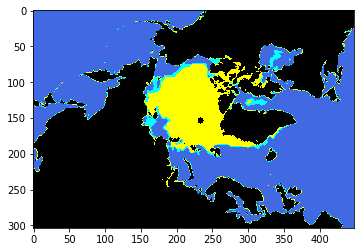

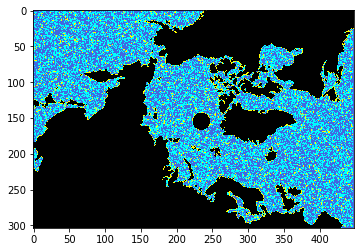

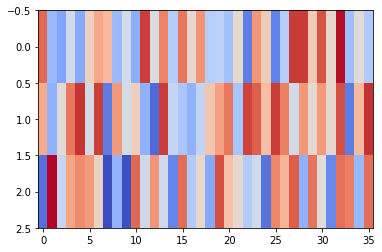

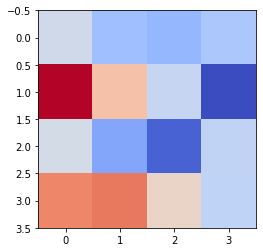

(304, 448)


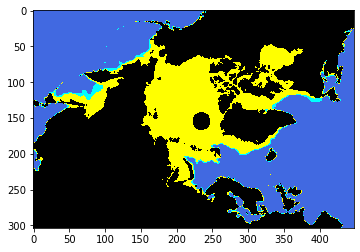

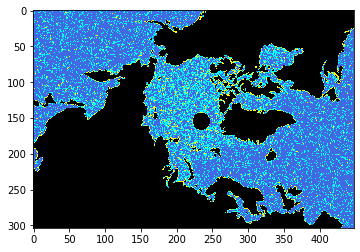

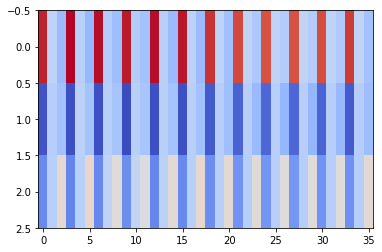

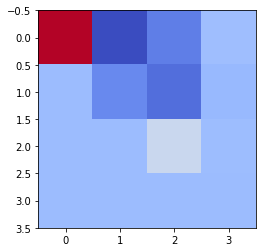

(304, 448)


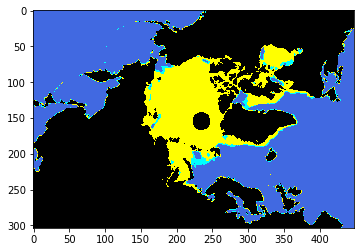

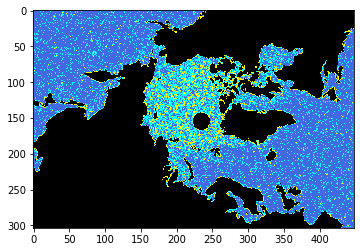

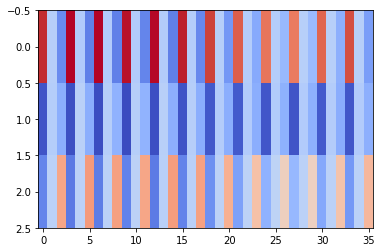

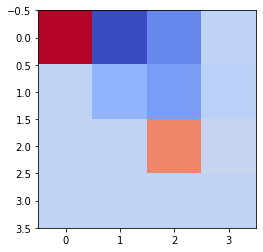

(304, 448)


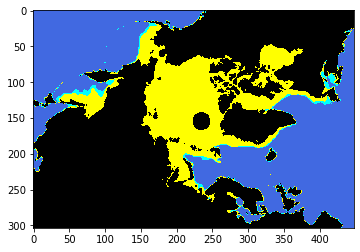

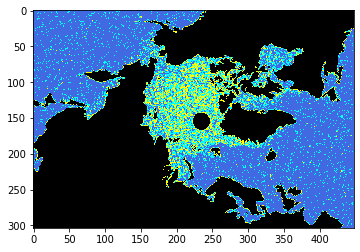

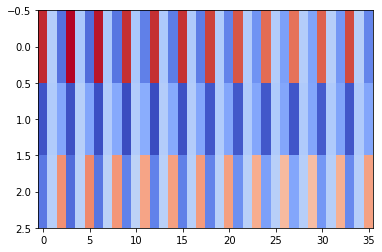

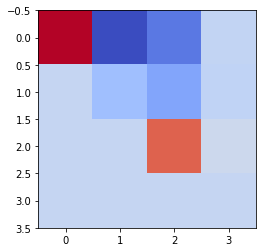

(304, 448)


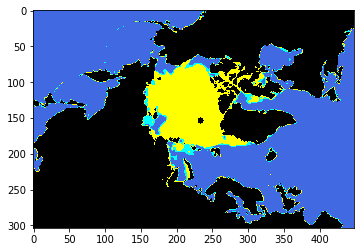

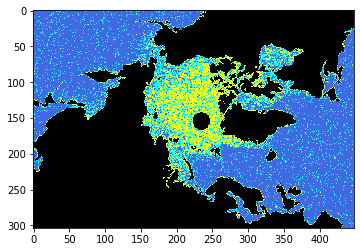

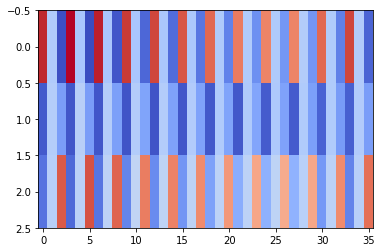

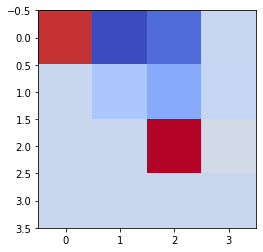

(304, 448)


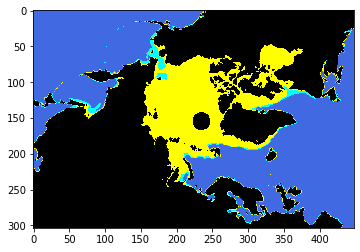

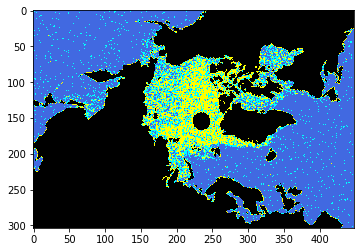

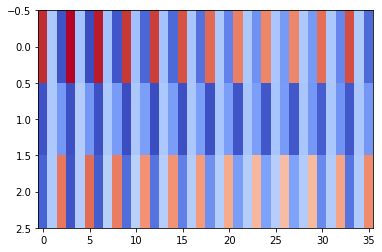

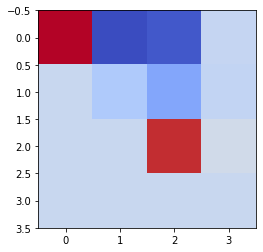

(304, 448)


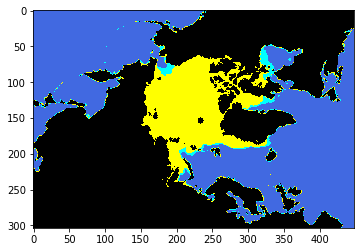

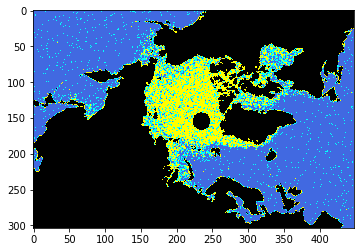

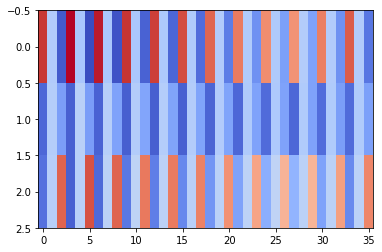

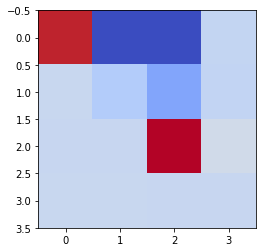

(304, 448)


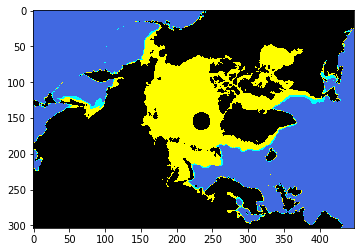

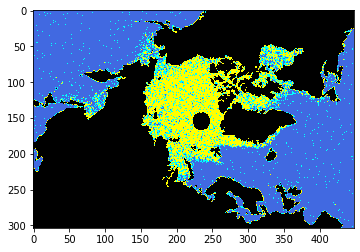

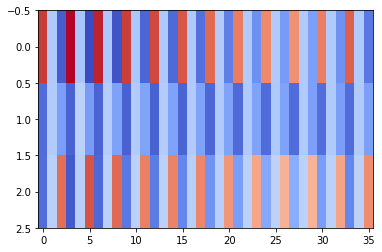

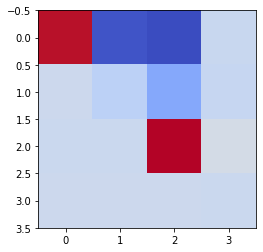

(304, 448)
****************VALIDATION***************


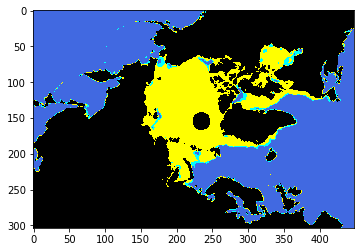

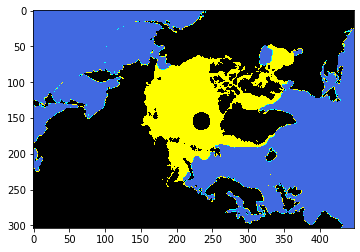

targ len 8
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
label one hot (8, 304, 448, 1)
(304, 448)


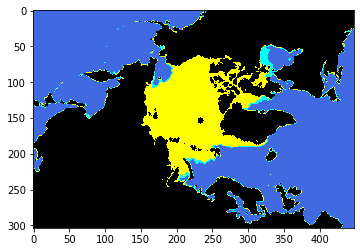

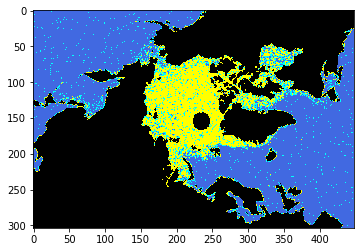

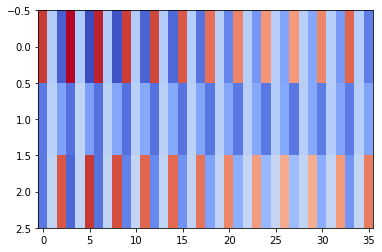

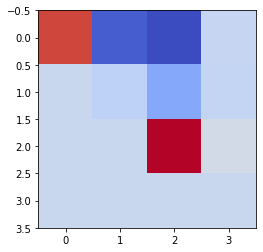

(304, 448)


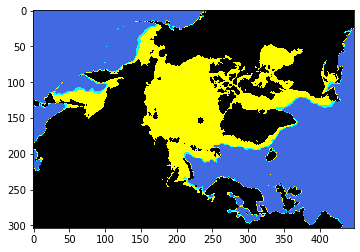

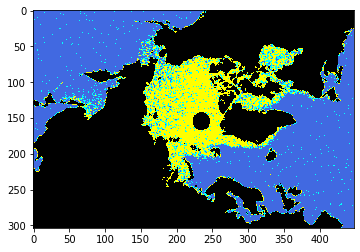

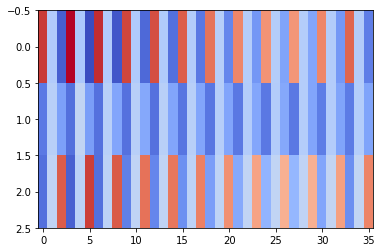

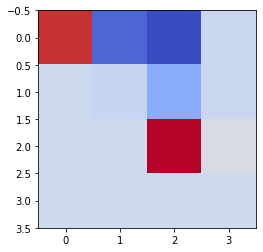

(304, 448)


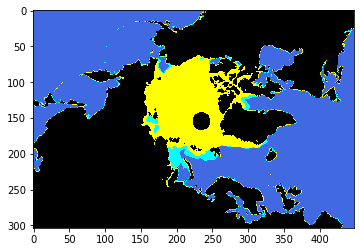

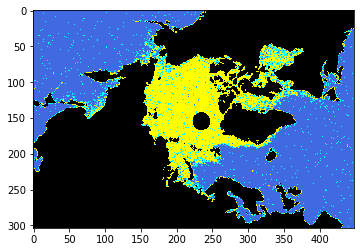

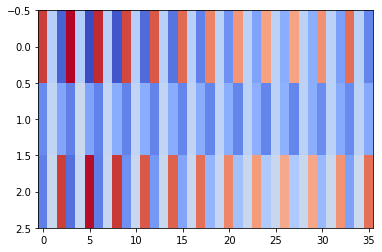

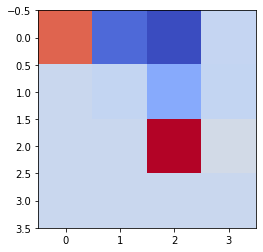

(304, 448)


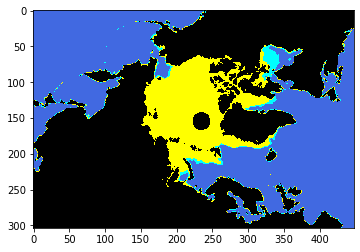

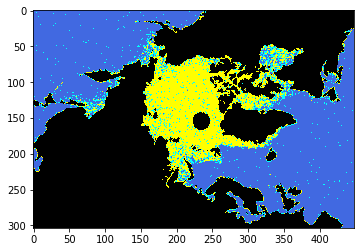

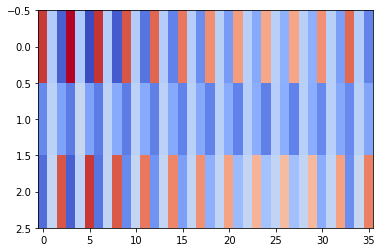

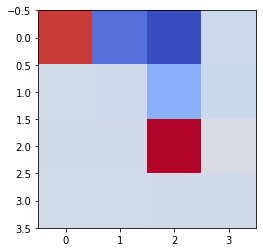

(304, 448)


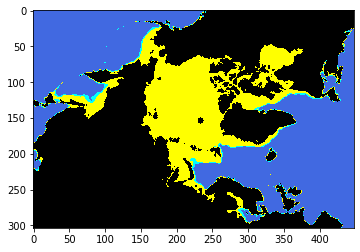

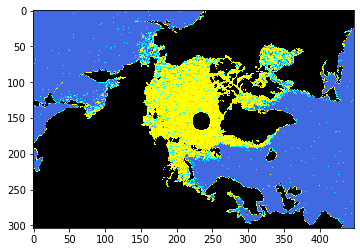

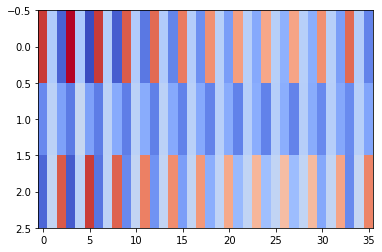

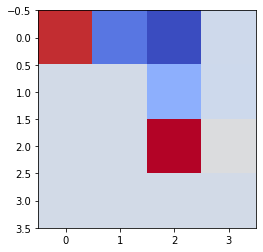

(304, 448)


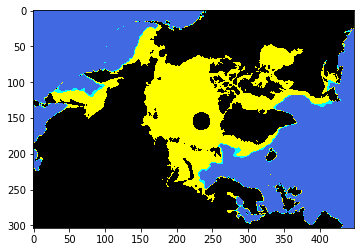

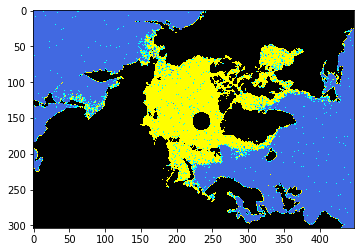

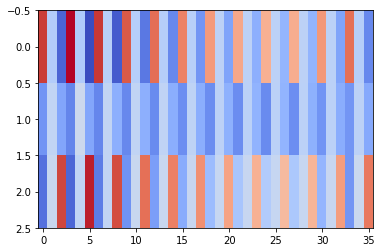

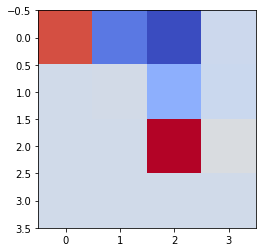

(304, 448)


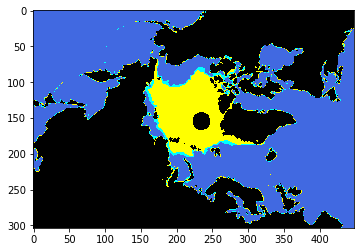

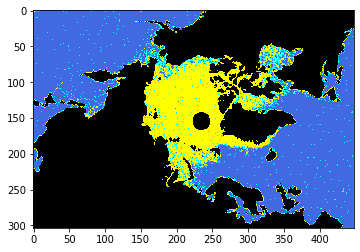

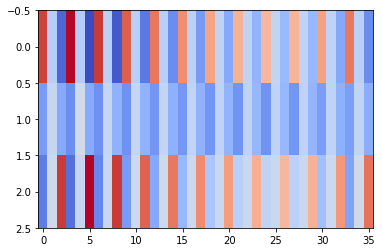

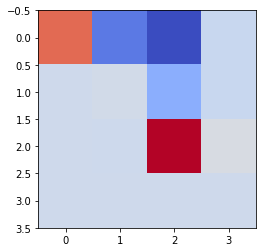

(304, 448)


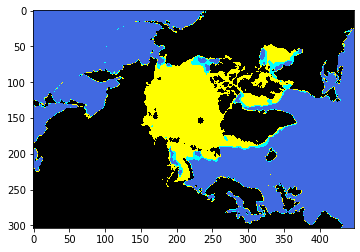

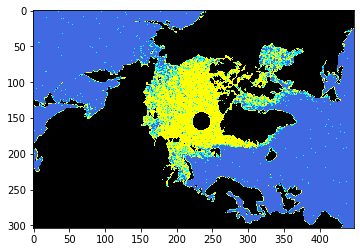

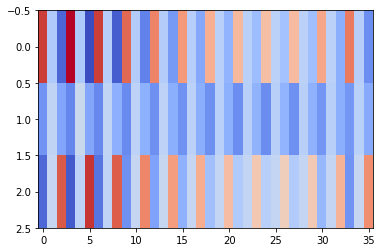

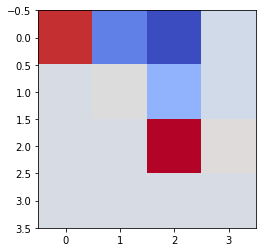

(304, 448)
****************VALIDATION***************


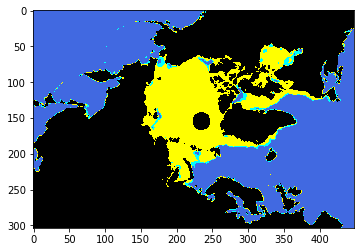

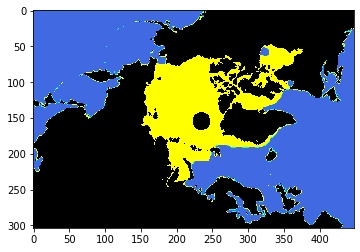

targ len 8
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
label one hot (8, 304, 448, 1)
(304, 448)


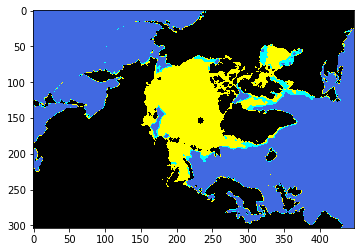

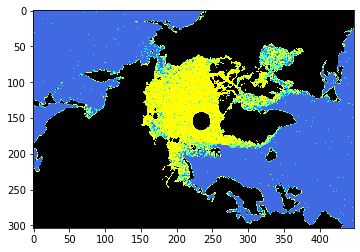

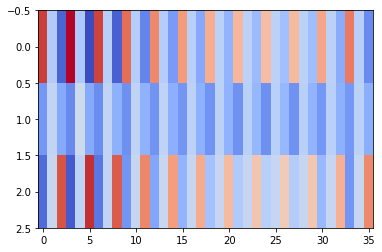

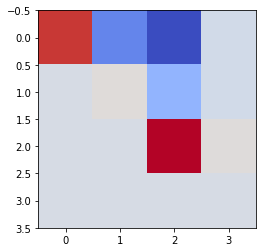

(304, 448)


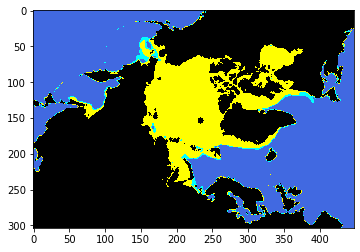

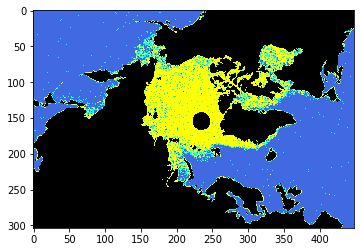

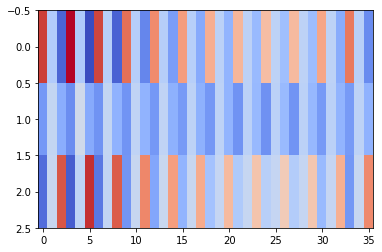

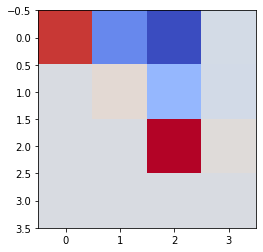

(304, 448)


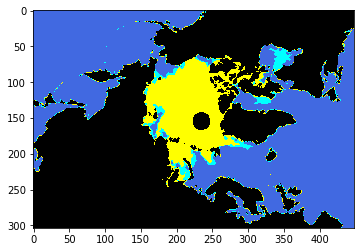

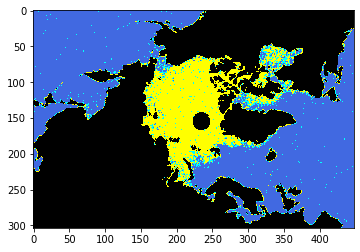

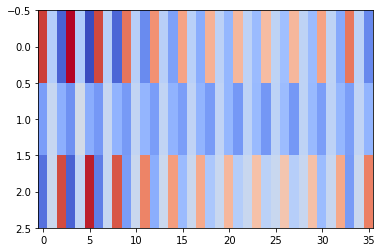

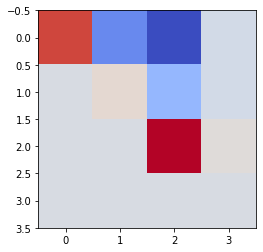

(304, 448)


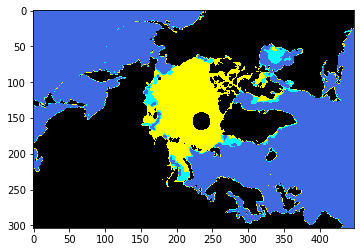

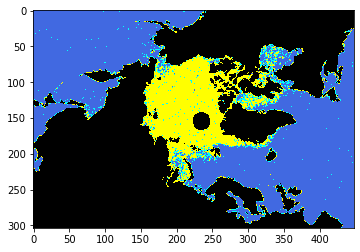

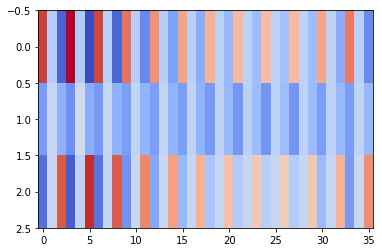

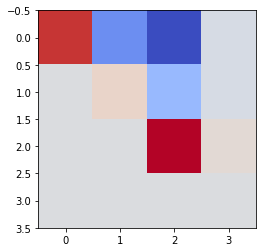

(304, 448)


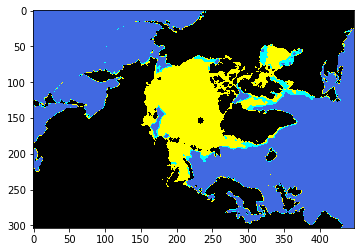

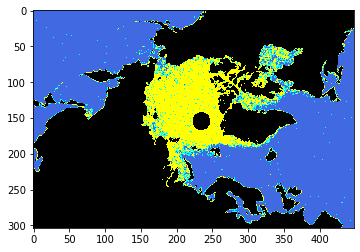

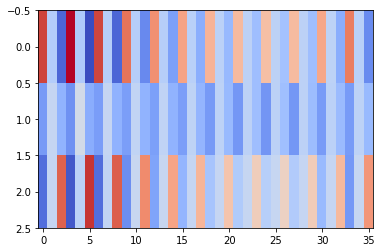

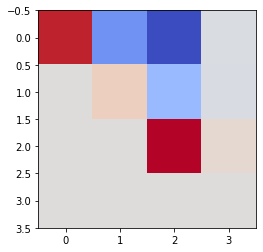

(304, 448)


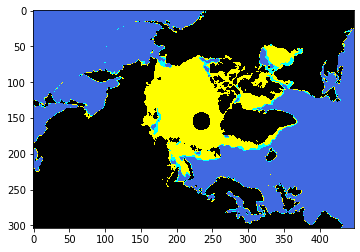

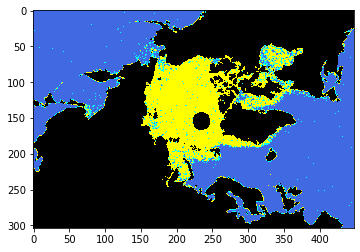

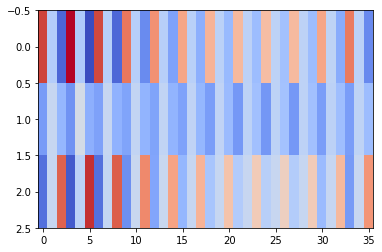

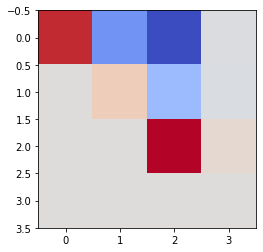

(304, 448)


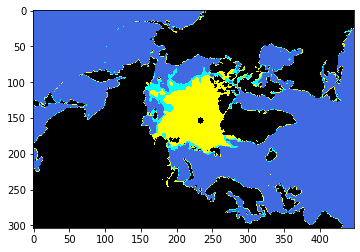

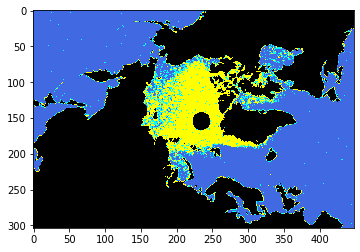

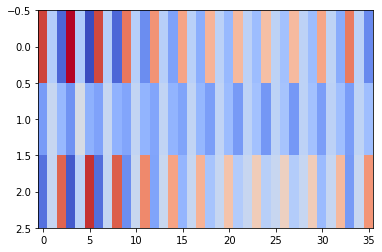

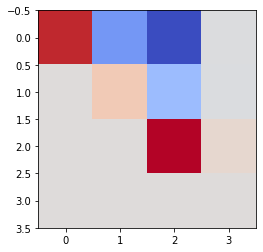

(304, 448)


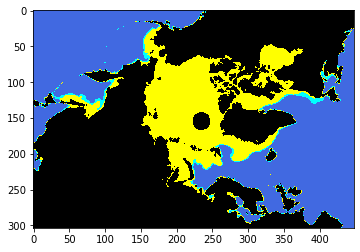

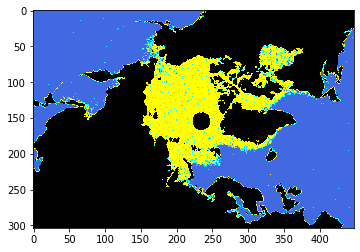

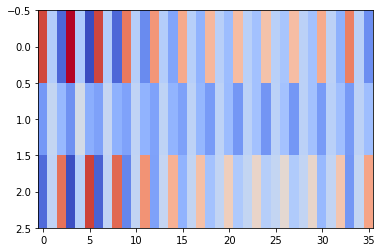

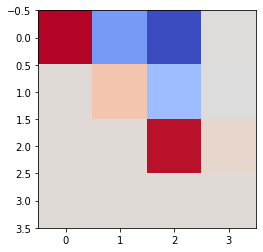

(304, 448)
****************VALIDATION***************


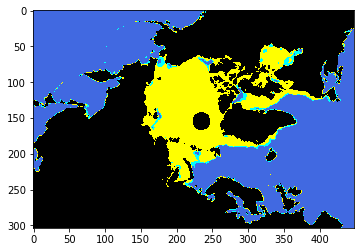

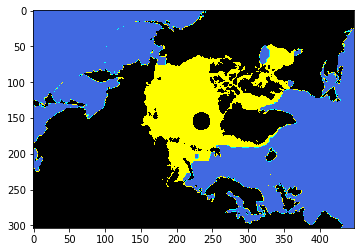

targ len 8
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
label one hot (8, 304, 448, 1)
(304, 448)


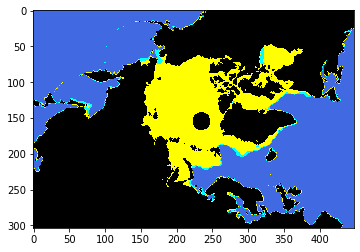

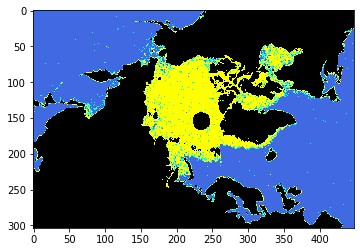

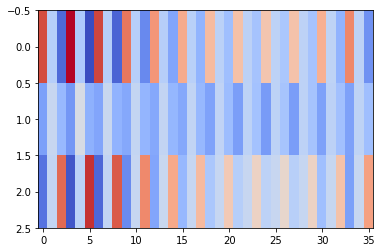

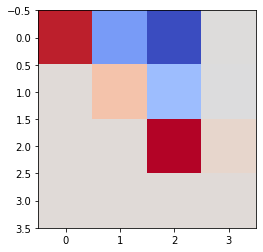

(304, 448)


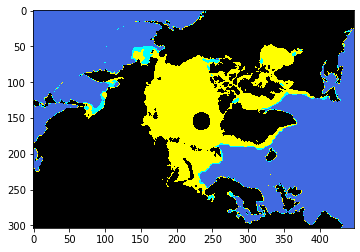

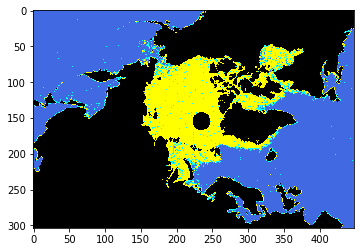

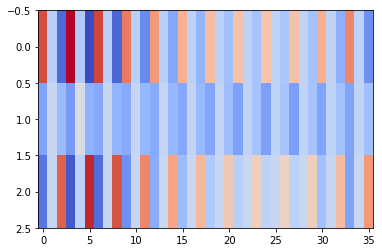

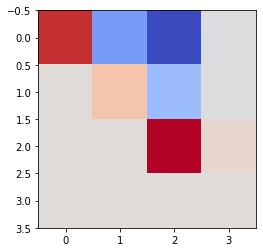

(304, 448)


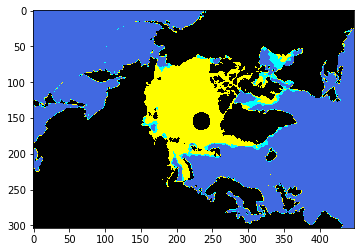

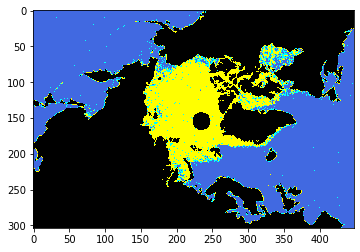

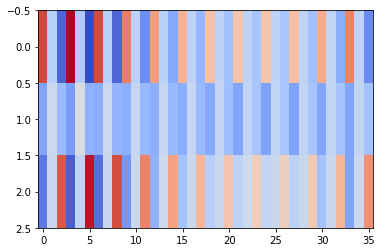

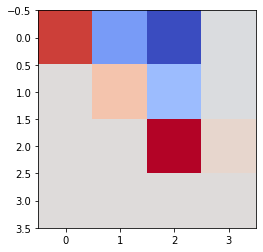

(304, 448)


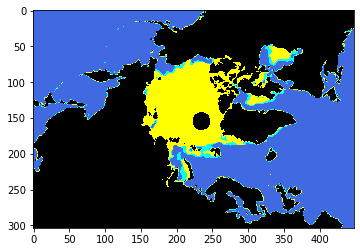

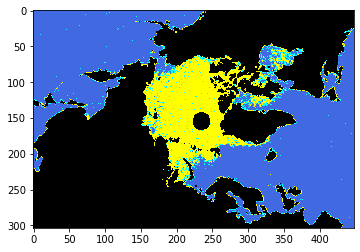

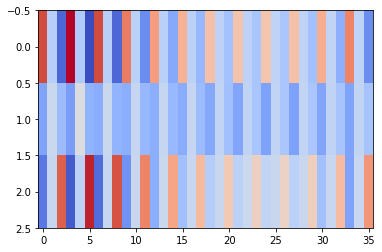

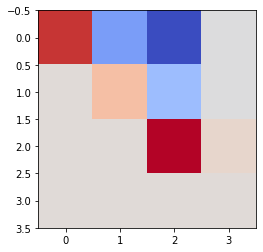

(304, 448)


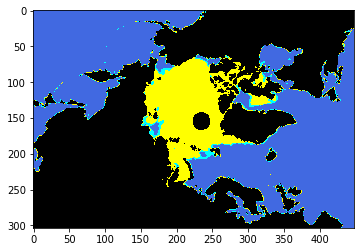

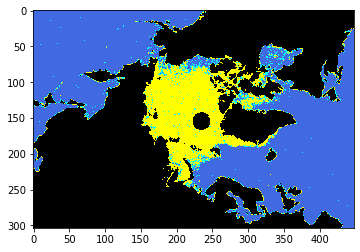

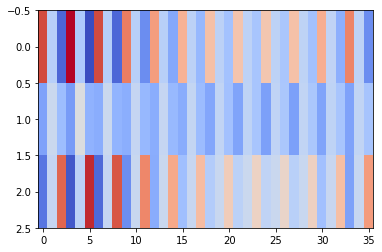

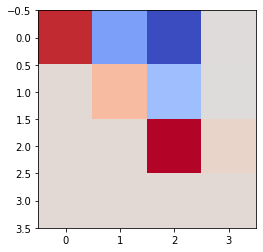

(304, 448)


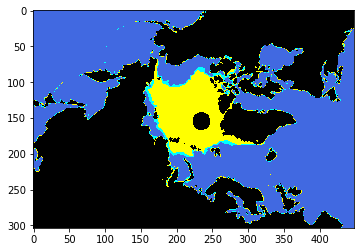

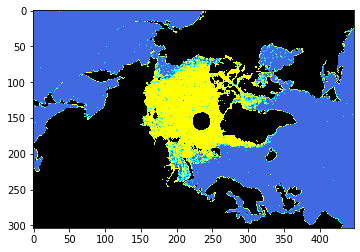

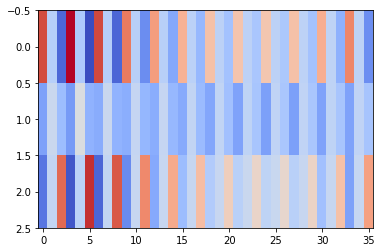

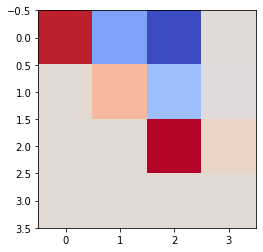

(304, 448)


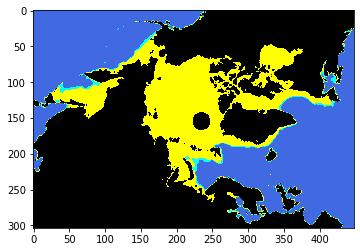

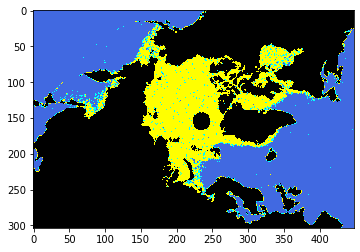

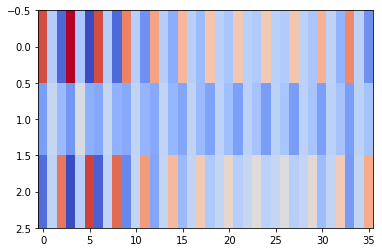

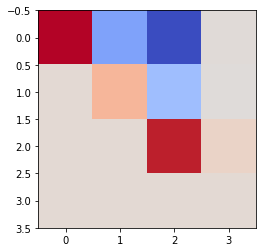

(304, 448)


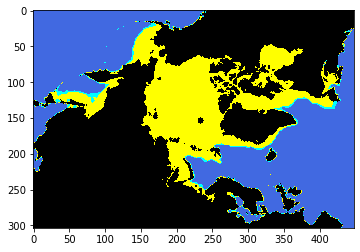

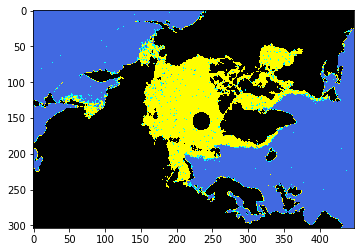

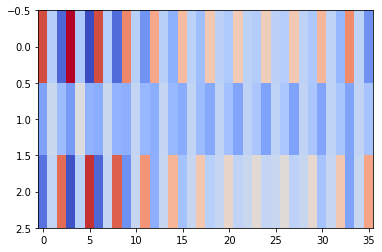

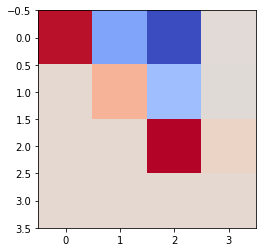

(304, 448)
****************VALIDATION***************


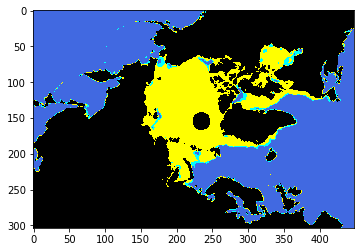

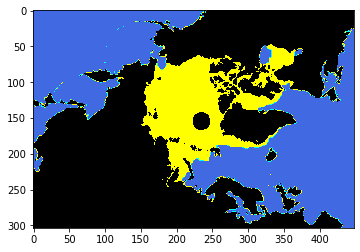

targ len 8
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
label one hot (8, 304, 448, 1)
(304, 448)


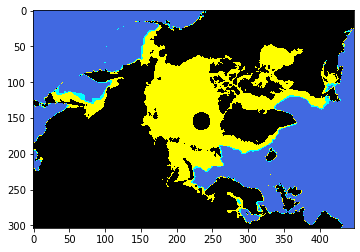

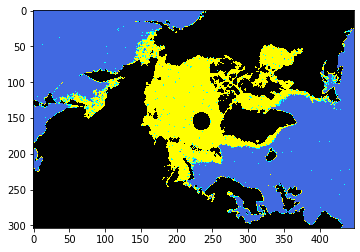

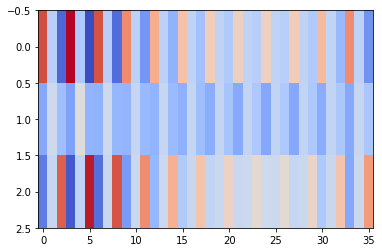

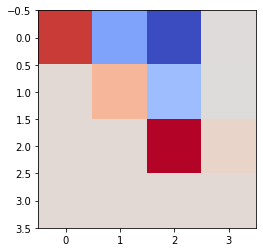

(304, 448)


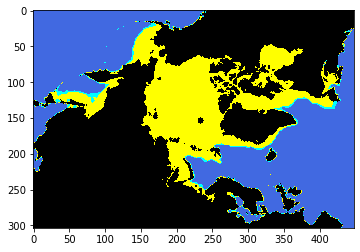

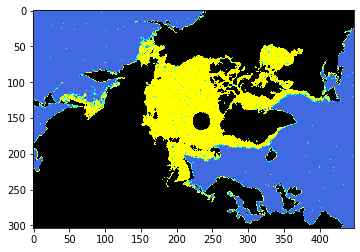

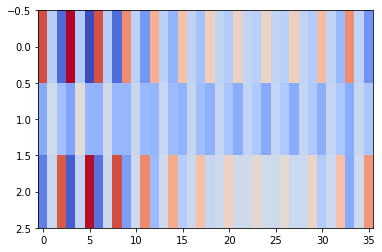

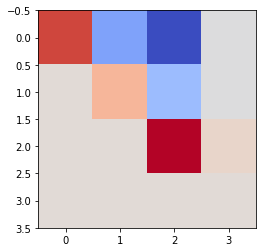

(304, 448)


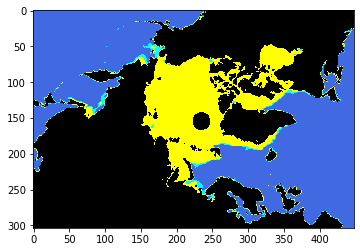

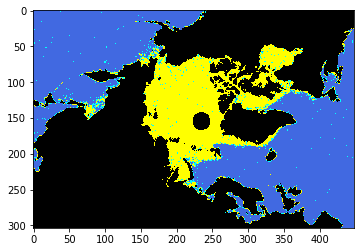

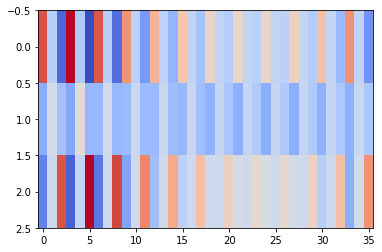

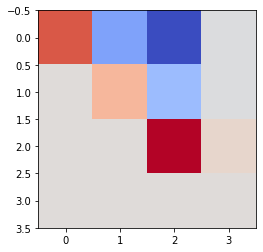

(304, 448)


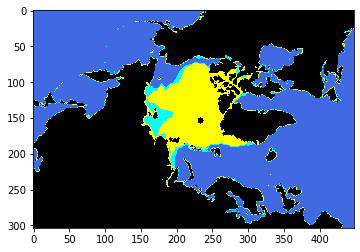

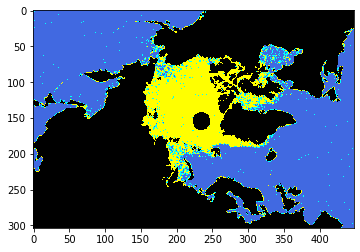

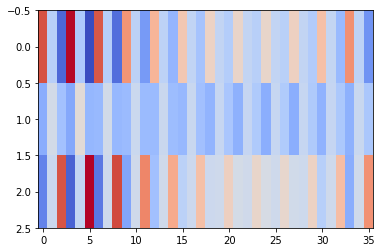

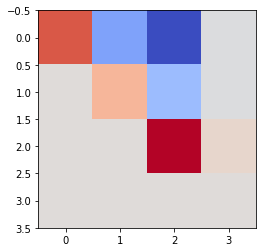

(304, 448)


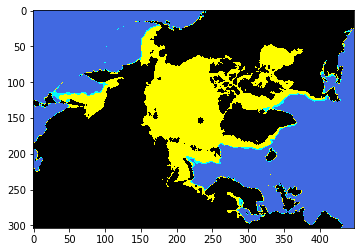

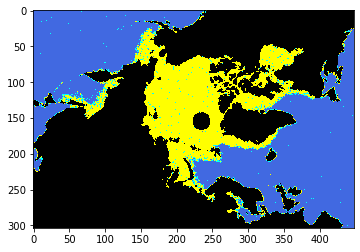

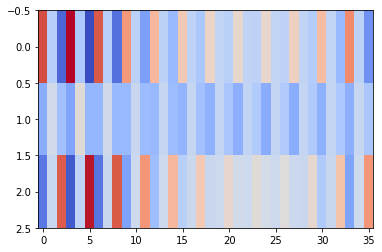

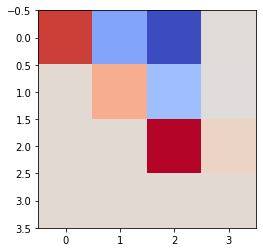

(304, 448)


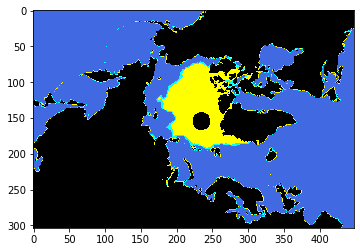

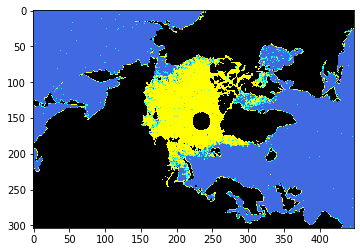

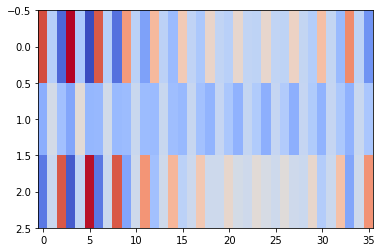

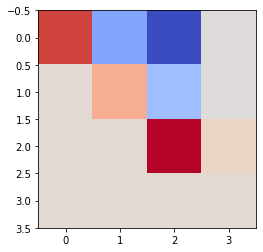

(304, 448)


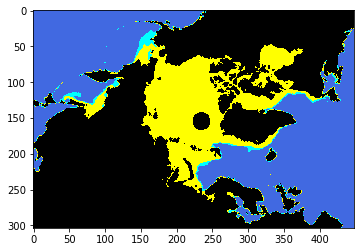

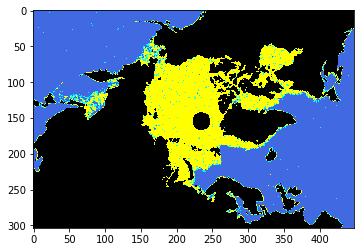

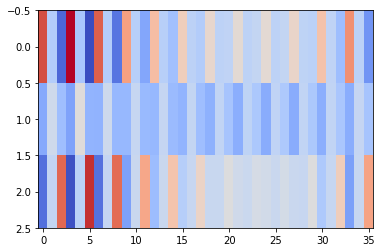

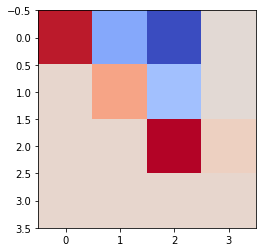

(304, 448)


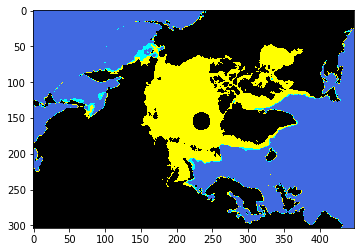

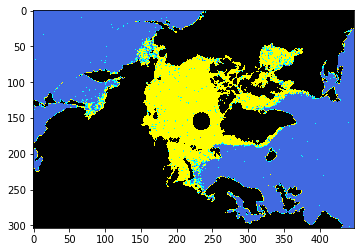

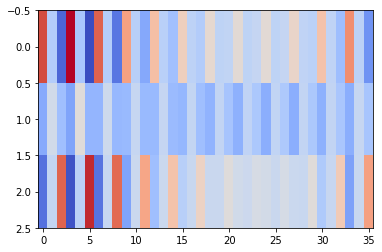

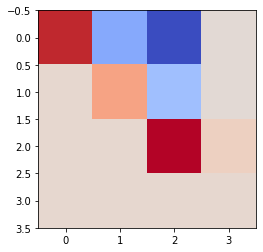

(304, 448)
****************VALIDATION***************


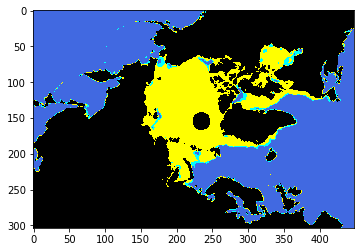

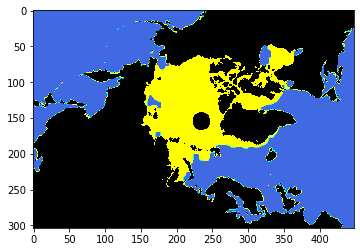

targ len 8
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
label one hot (8, 304, 448, 1)
(304, 448)


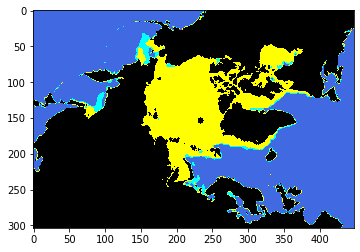

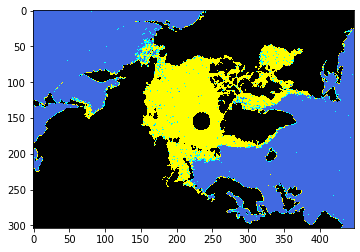

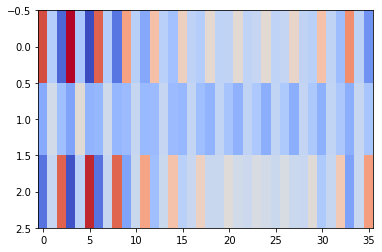

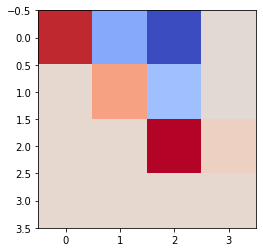

(304, 448)


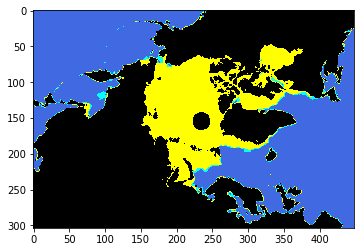

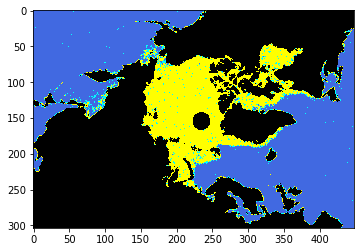

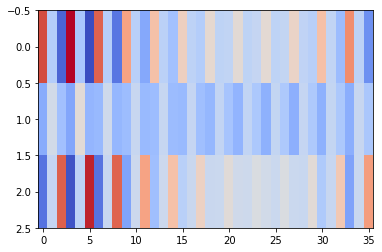

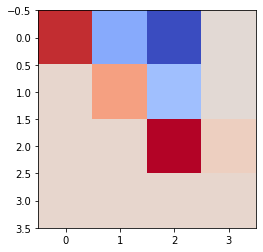

(304, 448)


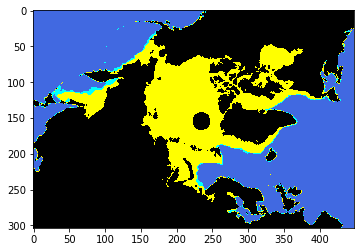

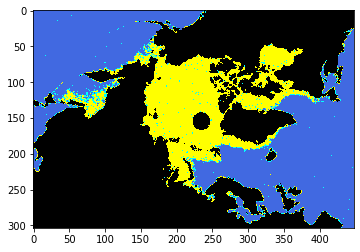

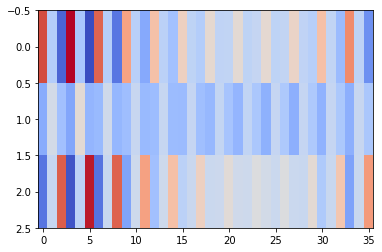

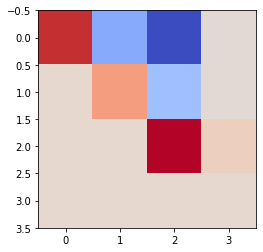

(304, 448)


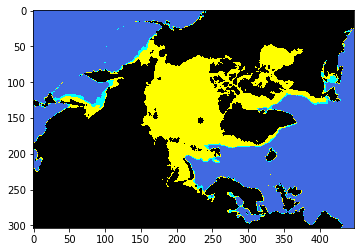

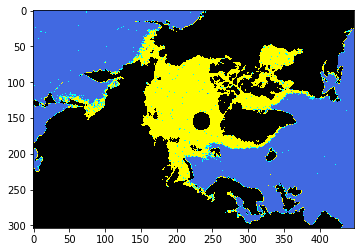

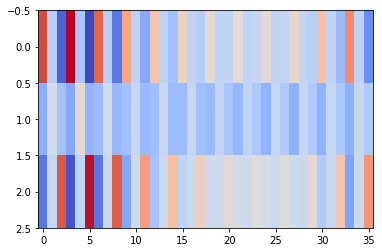

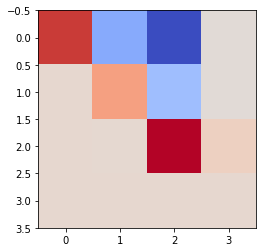

(304, 448)


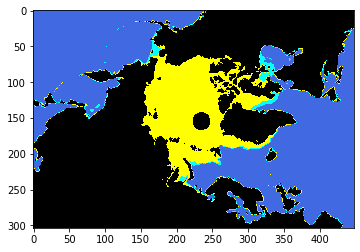

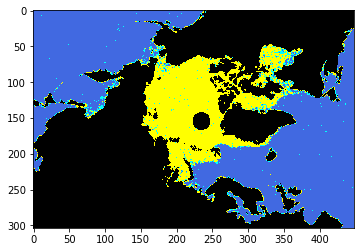

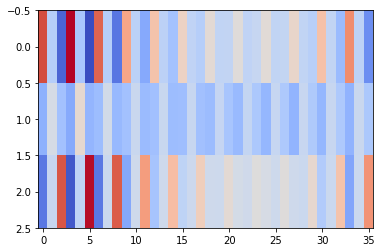

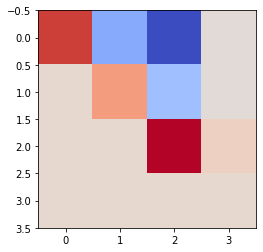

(304, 448)


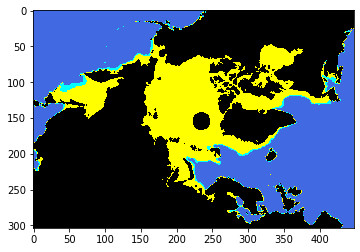

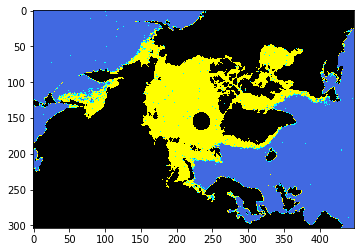

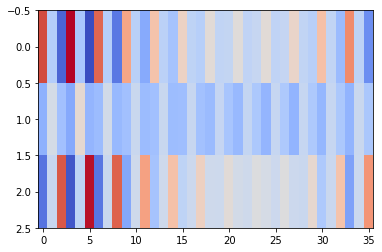

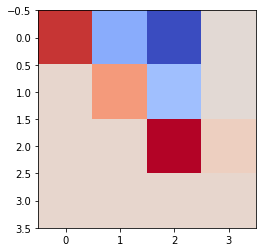

(304, 448)


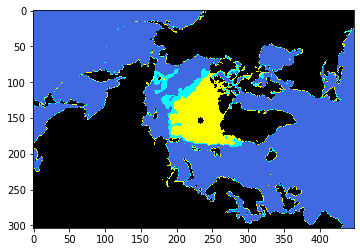

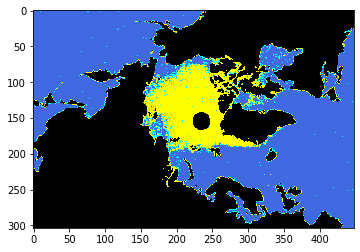

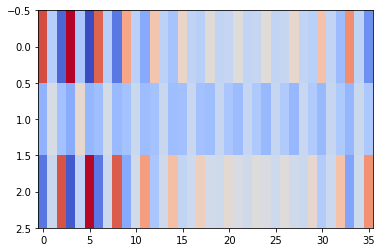

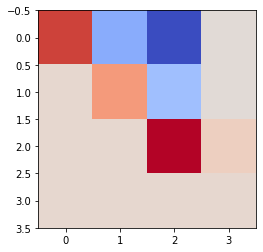

(304, 448)


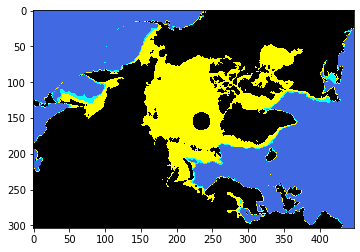

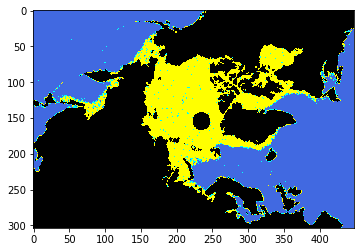

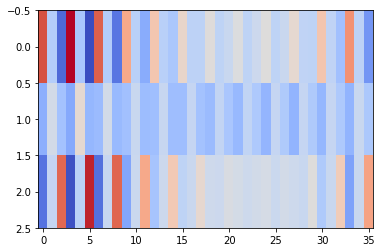

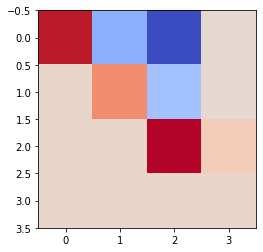

(304, 448)
****************VALIDATION***************


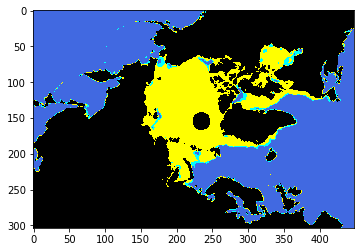

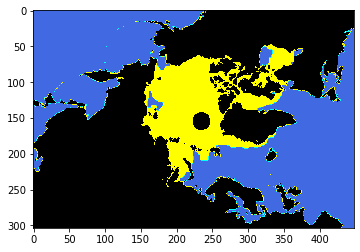

targ len 8
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
label one hot (8, 304, 448, 1)
(304, 448)


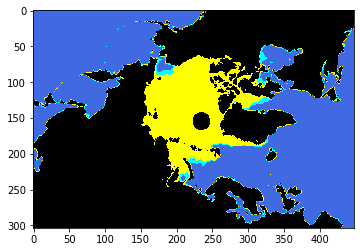

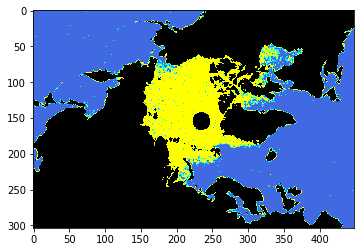

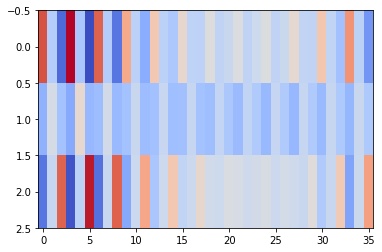

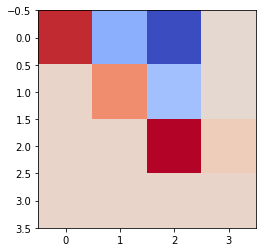

(304, 448)


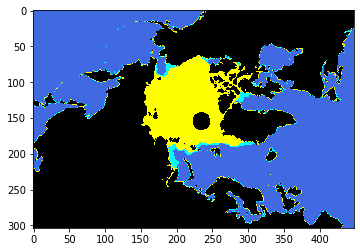

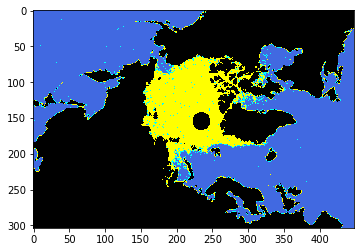

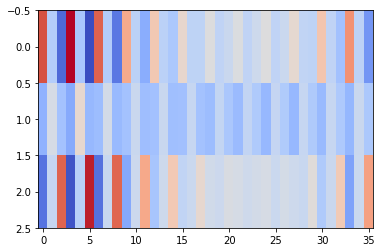

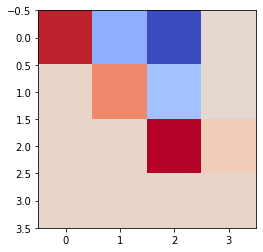

(304, 448)


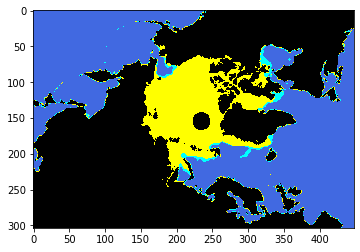

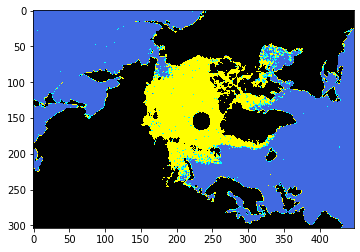

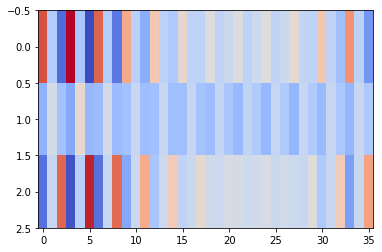

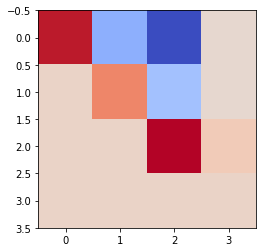

(304, 448)


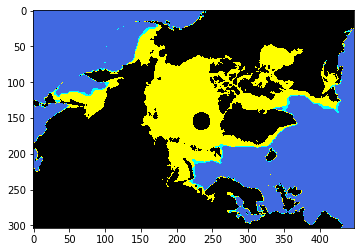

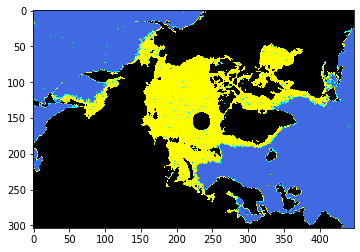

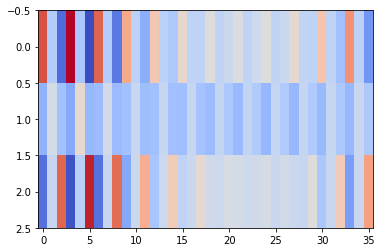

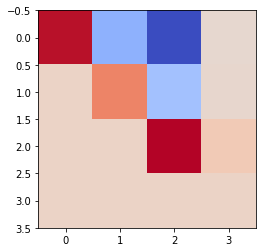

(304, 448)


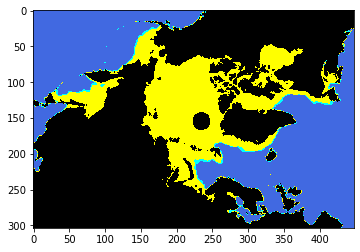

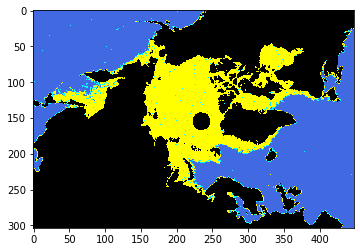

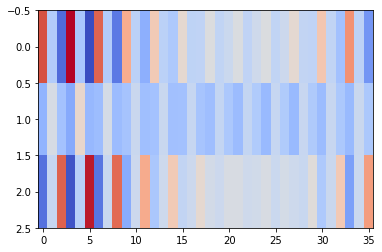

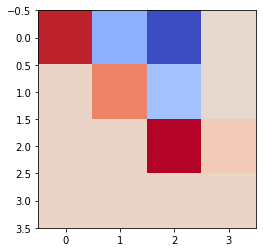

(304, 448)


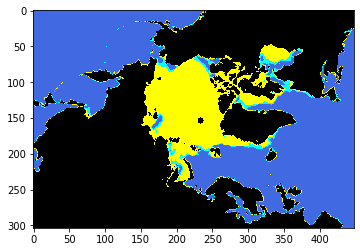

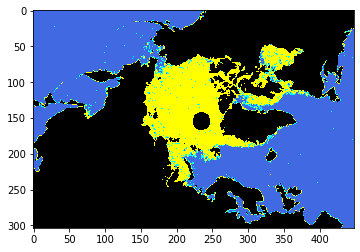

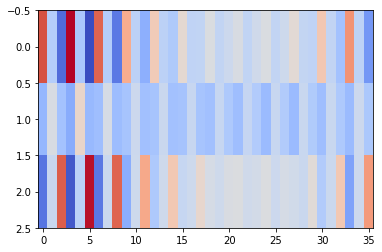

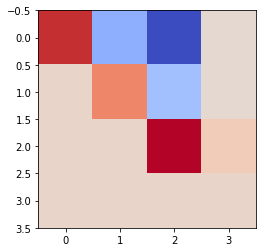

(304, 448)


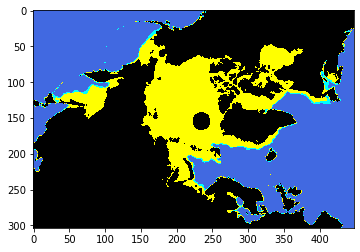

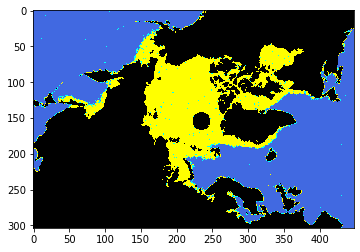

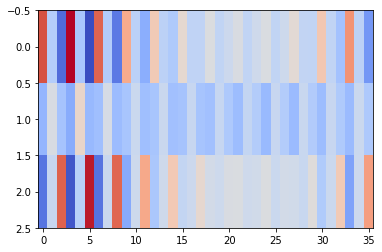

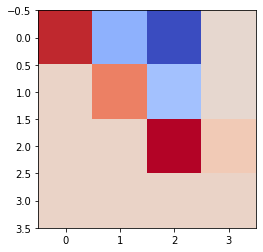

(304, 448)


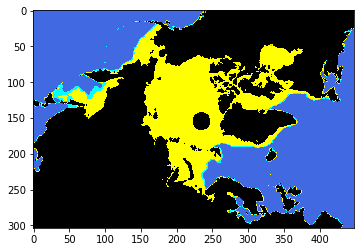

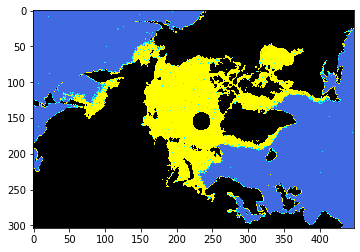

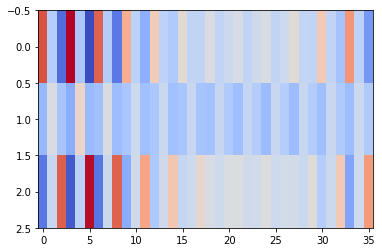

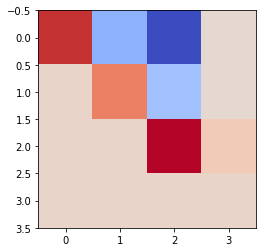

(304, 448)
****************VALIDATION***************


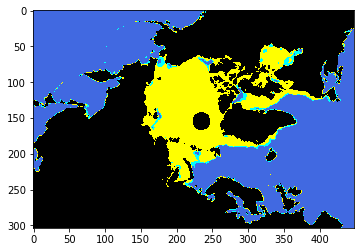

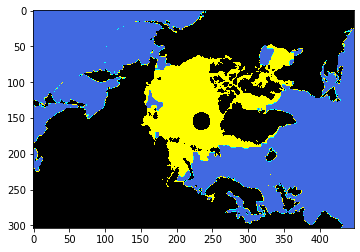

targ len 8
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
label one hot (8, 304, 448, 1)
(304, 448)


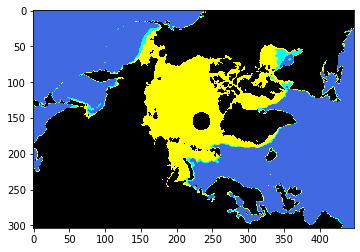

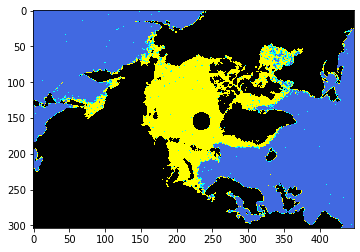

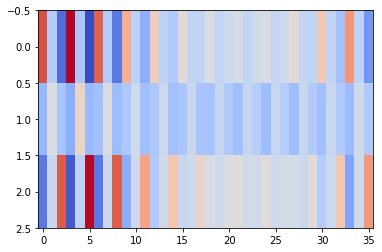

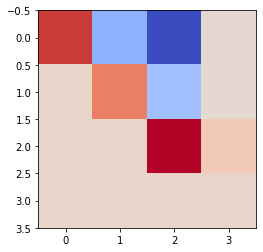

(304, 448)


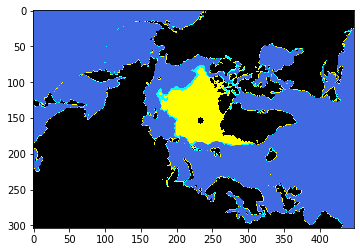

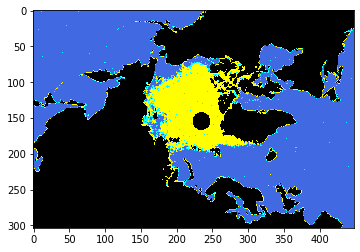

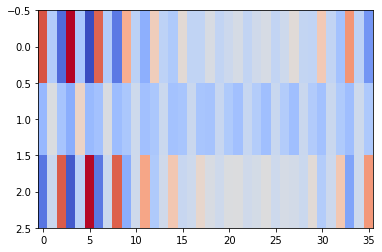

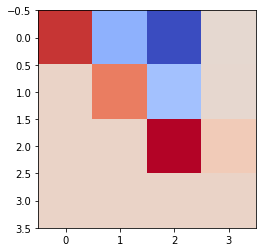

(304, 448)


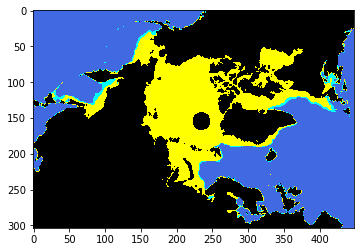

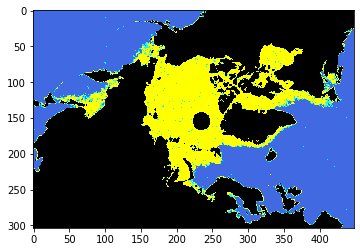

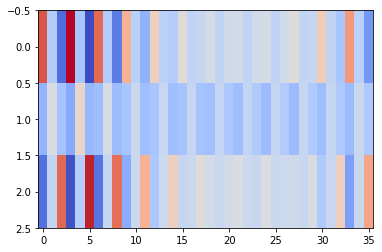

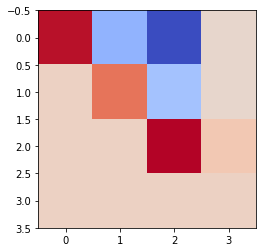

(304, 448)


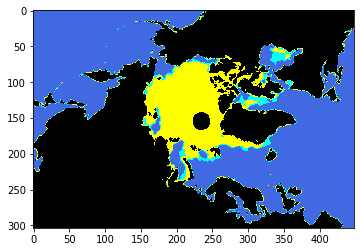

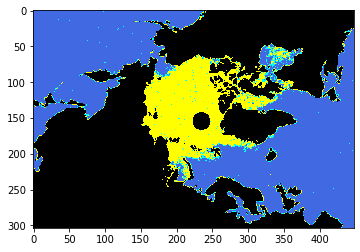

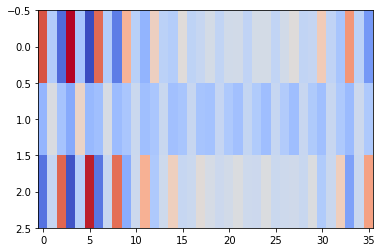

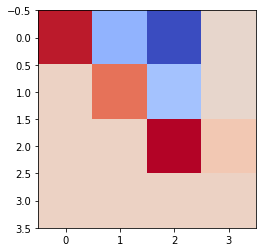

(304, 448)


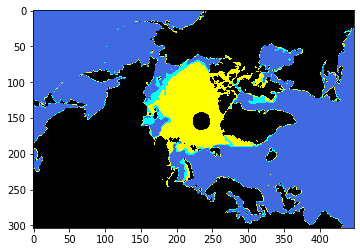

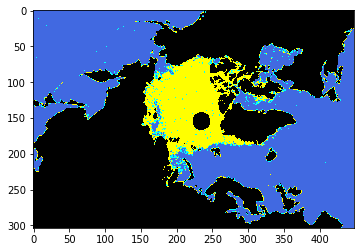

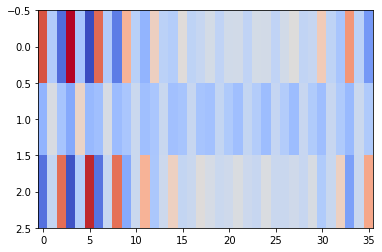

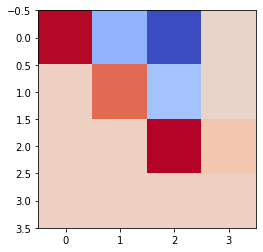

(304, 448)


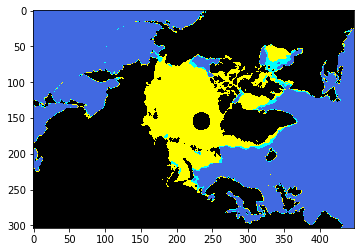

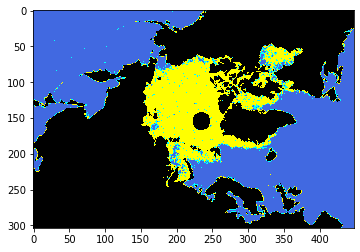

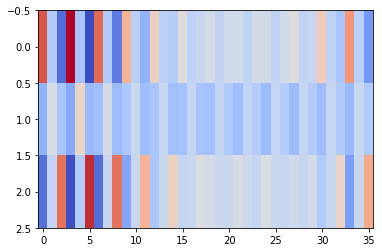

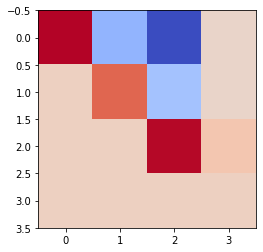

(304, 448)


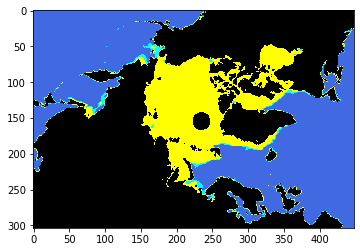

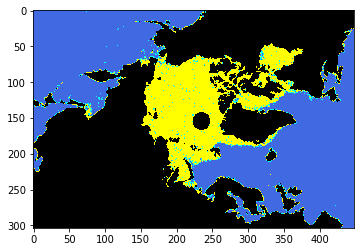

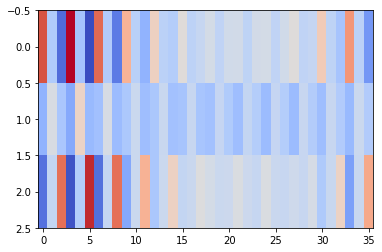

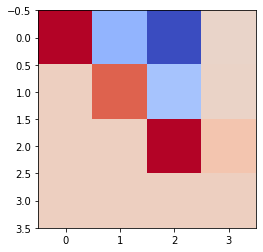

(304, 448)


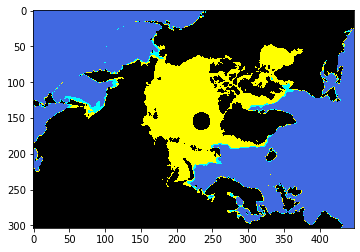

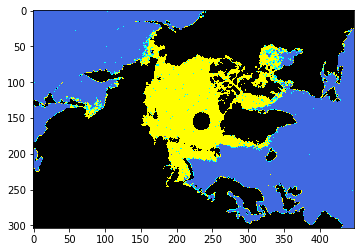

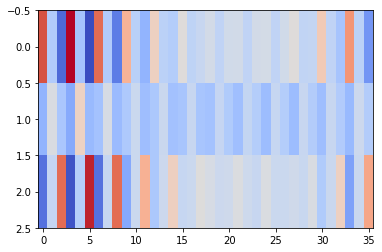

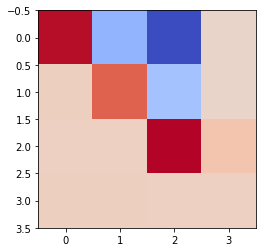

(304, 448)
****************VALIDATION***************


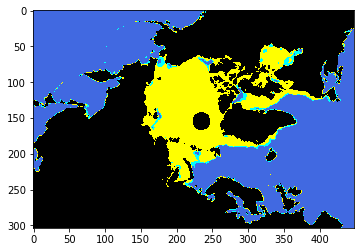

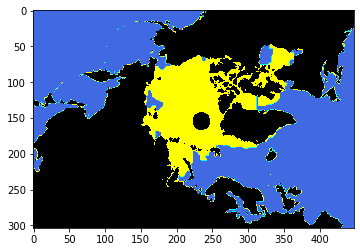

targ len 8
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
img (12, 304, 448, 1)
lbl (304, 448, 1)
label one hot (8, 304, 448, 1)
(304, 448)


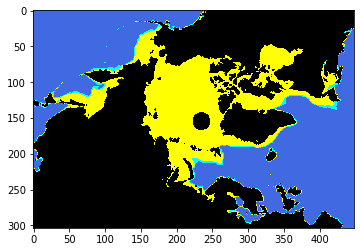

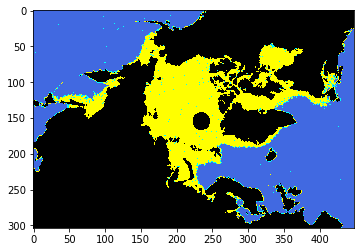

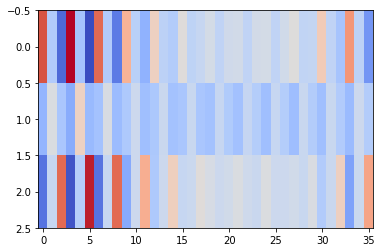

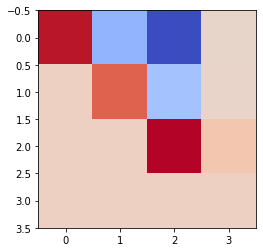

(304, 448)


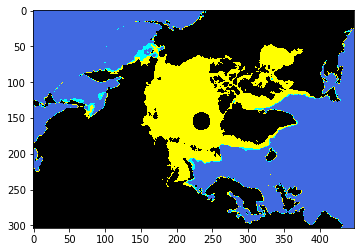

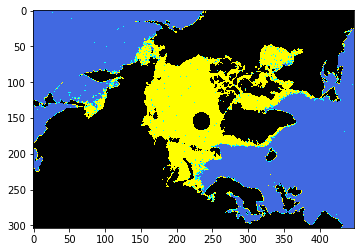

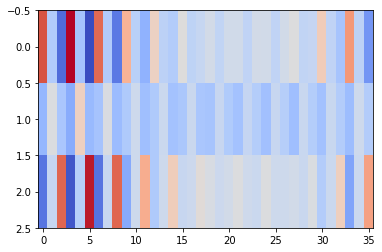

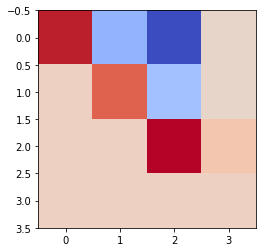

(304, 448)


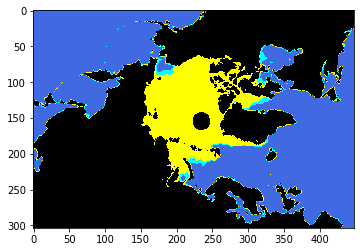

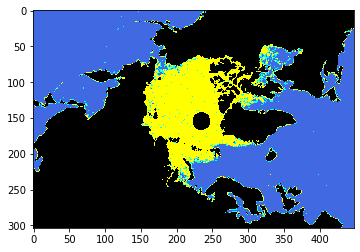

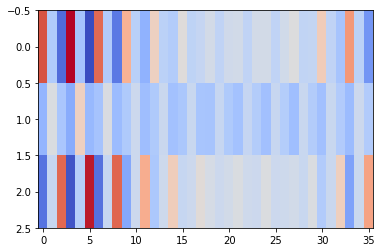

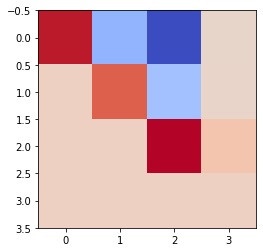

(304, 448)


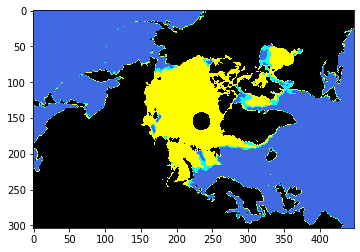

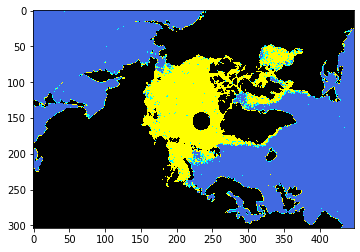

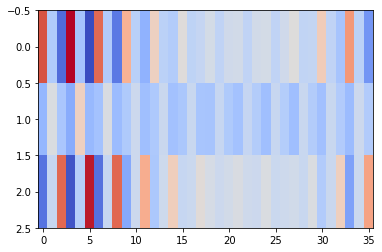

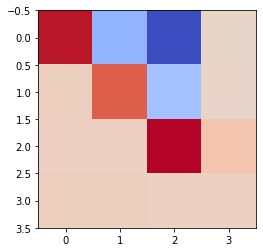

(304, 448)


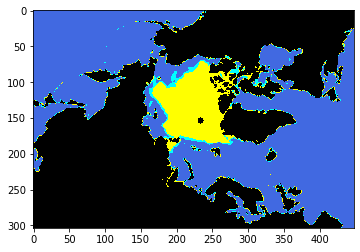

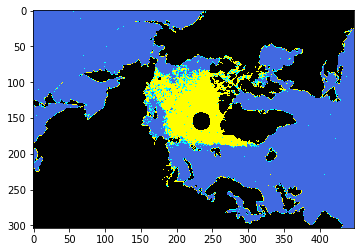

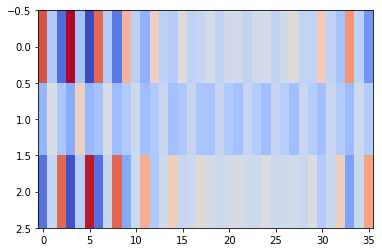

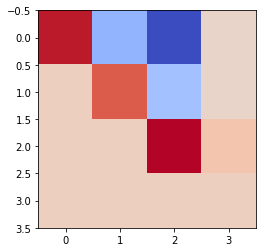

In [ ]:
#initialize theta and phi with random weights
theta=np.random.uniform(low=-.0001, high=.00011,size=( 3,fixed_num_months*3))
phi=np.random.uniform(low=-.0001, high=.00011,size=( 4,4))

#initialize average theta and average phi
a=np.zeros((3,fixed_num_months*3))
ap=np.zeros((4,4))
an=np.zeros((3,fixed_num_months*3))
apn=np.zeros((4,4))

r=.000001
for epoch in range(num_epochs):
  batch=generate_train_feed()
  for x, y in zip(batch['images'],batch['labels']):
    ybar=inference(x,theta,phi)
    plot_prediction_img(y)
    plot_prediction_img(ybar)
    plt.imshow(theta, cmap='coolwarm', interpolation='nearest',aspect='auto')
    plt.show()
    plt.imshow(phi, cmap='coolwarm', interpolation='nearest')
    plt.show()
    for i, j in aoi_coords:
      #ignore boundary
      if i==0 or i>=303:
        continue
      if j==0 or j>=447:
        continue
      correct_y=y[i][j][0]
      pred_y=ybar[i][j]
      # print(correct_y, pred_y)
      if correct_y != pred_y:
        if(correct_y==3):
          continue
        theta[correct_y]+=r*x[i][j] #promote correct weight
        theta[pred_y]-=r*x[i][j]  #demote incorrect weight
        nighbor_ys=getNeighbors(i,j,y)
        neighbor_ybars=getNeighbors(i,j,ybar)
        for yn,ynbar in zip(nighbor_ys,neighbor_ybars):
          # print(yn,ynbar)
          if (yn[0]<correct_y):
            phi[yn[0]][correct_y]+=r*1
          else:
            phi[correct_y][yn[0]]+=r*1
          if (ynbar<pred_y):
            phi[ynbar][pred_y]-=r*1
          else:
            phi[pred_y][ynbar]-=r*1
    a+=theta
    ap+=phi
    an+=theta
    apn+=phi
    # np.save(save_path+'a_runf_00001_12n',a)
    # np.save(save_path+'ap_runf_00001_12n',ap)
    # np.save(save_path+'an_runf_00001_12n',an)
    # np.save(save_path+'apn_runf_00001_12n',apn)
    # np.save(save_path+'theta_runf_00001_12n',theta)
    # np.save(save_path+'phi_runf_00001_12n',phi)
    # print(theta,phi)
  for c in range(3):
    an[c]=an[c]/np.linalg.norm(an[c])
  apn=apn/np.linalg.norm(apn)
  for x, y in zip(val['images'],val['labels']):
    prediction=inference(x,a,ap)
    print("****************VALIDATION***************")
    plot_prediction_img(y)
    plot_prediction_img(prediction)


    


***Prediction***

In [ ]:
for i in range(12):
  start=i
  val=generate_val_feed(start)
  print('for month',i)
  for x, y in zip(val['images'],val['labels']):
    plot_prediction_img(y)
    prediction=inference(x,theta,phi)
    plot_prediction_img(prediction)
    plot_accuracy(y-np.expand_dims(prediction,axis=-1))

In [ ]:
for i in range(12):
  start=i
  val=generate_test_feed(start)
  print('for month',i)
  for x, y in zip(val['images'],val['labels']):
    plot_prediction_img(y)
    prediction=inference(x,theta,phi)
    plot_prediction_img(prediction)
    plot_accuracy(y-np.expand_dims(prediction,axis=-1))